#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    z = y * (X @ w + w0)
    logistic = np.where(z > 0, np.log1p(np.exp(-z)), -z + np.log1p(np.exp(z)))
    data_loss = np.mean(logistic)
    reg_l1 = gamma * (np.sum(np.abs(w)))
    reg_l2 = beta * np.dot(w, w)
    return float(data_loss + reg_l1 + reg_l2)

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    N = X.shape[0]
    z = y * (X @ w + w0)
    frac = y / (1.0 + np.exp(z))
    grad_w = -(X.T @ frac) / N + gamma * np.sign(w) + 2.0 * beta * w
    grad_w0 = -np.sum(frac)/N
    return grad_w.tolist(), float(grad_w0)

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

отработала, круто, идем дальше

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge
        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w_ = None
        self.w0_ = 0.0
        self.loss_history_ = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        if set(np.unique(y)) == {0.0, 1.0}:
            y = np.where(y == 0.0, -1.0, 1.0)

        n, m = X.shape
        rng = np.random.RandomState(self.random_state)

        self.w_ = np.zeros(m, dtype=float)
        self.w0_ = 0.0
        self.loss_history_ = []

        self.loss_history_.append(
            loss(X, y, self.w_, self.w0_, gamma=self.gamma, beta=self.beta)
        )

        for _ in range(self.max_iter):
            i = rng.randint(0, n)
            gw, gw0 = get_grad(X[i:i+1], y[i:i+1], self.w_, self.w0_,
                               gamma=self.gamma, beta=self.beta)
            gw = np.asarray(gw, dtype=float)

            step_w  = self.lr * gw
            step_w0 = self.lr * gw0
            self.w_  -= step_w
            self.w0_ -= step_w0

            cur_loss = loss(X, y, self.w_, self.w0_, gamma=self.gamma, beta=self.beta)
            self.loss_history_.append(cur_loss)

            if np.dot(step_w, step_w) + step_w0**2 < self.tolerance:
                break
        return self

    def predict(self, X):
        p = self.predict_proba(X)
        return (p >= 0.5).astype(int)

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        z = X @ self.w_ + self.w0_
        z = np.clip(z, -40.0, 40.0)   # численная стабильность
        p = 1.0 / (1.0 + np.exp(-z))
        return p


In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y, h: float = 0.02, padding: float = 0.5,
                           cmap="RdBu", ax=None, show=True):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y)

    if X.shape[1] != 2:
        raise ValueError("plot_decision_boundary ожидает X с двумя признаками.")
    if set(np.unique(y)) == {0, 1}:
        y_plot = np.where(y == 0, -1, 1)
    else:
        y_plot = y.copy()

    x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding
    y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    try:
        proba = model.predict_proba(grid).reshape(xx.shape)
    except AttributeError:
        proba = model.predict(grid).astype(float).reshape(xx.shape)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    else:
        fig = ax.figure

    im = ax.contourf(xx, yy, proba, levels=50, cmap=cmap, alpha=0.6)

    ax.contour(xx, yy, proba, levels=[0.5], colors="red", linewidths=2)

    ax.scatter(X[y_plot == 1, 0],  X[y_plot == 1, 1],
               c="k", s=20, edgecolor="white", label="+1")
    ax.scatter(X[y_plot == -1, 0], X[y_plot == -1, 1],
               c="w", s=20, edgecolor="black", label="-1")

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend(loc="upper right")
    ax.set_title("Decision boundary (p=0.5)")

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("P(y=+1)")

    if show:
        plt.show()

    return fig, ax

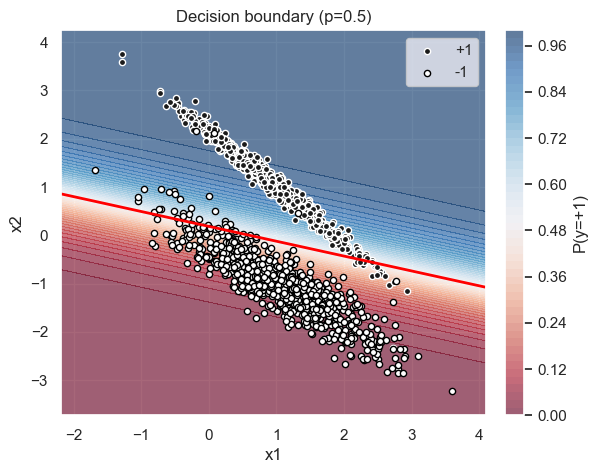

(<Figure size 600x500 with 2 Axes>,
 <Axes: title={'center': 'Decision boundary (p=0.5)'}, xlabel='x1', ylabel='x2'>)

In [ ]:
model = Logit(beta=0.0, gamma=0.0, lr=1e-2, max_iter=2000).fit(X, y)
plot_decision_boundary(model, X, y)

In [ ]:
model.loss_history_

[0.6931471805599452,
 0.689435601925854,
 0.6870439841702143,
 0.686920553414506,
 0.6839420627577935,
 0.6809059842417999,
 0.6803341002226424,
 0.6785910630485905,
 0.6759915275297619,
 0.6736649527113215,
 0.6693351206615734,
 0.6696575319427299,
 0.6682745031311225,
 0.6658441504268503,
 0.6651903696598732,
 0.6628345072558002,
 0.6595431880116455,
 0.6571671186990186,
 0.6558243022244037,
 0.6543921185234702,
 0.6493602443446669,
 0.6523153729848408,
 0.6489597062654368,
 0.6464166939739427,
 0.6437426279190863,
 0.6396981750486814,
 0.6363767798361085,
 0.6344193101935326,
 0.6331573288866216,
 0.6304250279731273,
 0.6281507816274322,
 0.6273755814300739,
 0.624432257617695,
 0.6199593018421111,
 0.6168893684167706,
 0.6156261528020216,
 0.6135565496388117,
 0.6125217297711623,
 0.6124464090522836,
 0.612384797786612,
 0.6093006779782846,
 0.605563282296254,
 0.6040470432726064,
 0.6015658621417073,
 0.5991182588029879,
 0.5984553694072474,
 0.5984790501422476,
 0.604009739328455

вижу, что реально уменьшается - отлично, идем дальше, ниже на графике будет наглядно видно это красиво

чтобы случайно нижний не запустить, буду иметь в виду

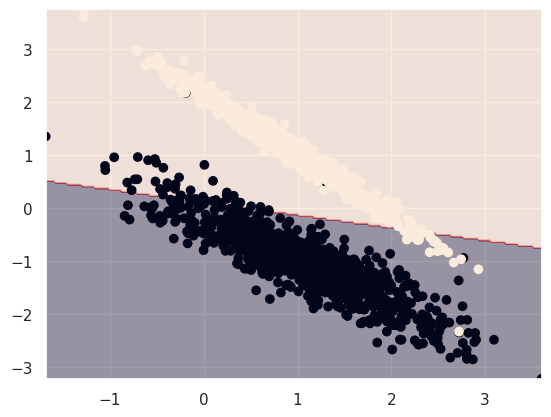

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    hist = getattr(model, "loss_history_", None)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(np.arange(1, len(hist) + 1), hist, lw=2)
    ax.set_xlabel("Итерация")
    ax.set_ylabel("Значение loss")
    ax.set_title("Динамика функции потерь (train)")
    ax.grid(True, alpha=0.3)
    plt.show()
    return fig, ax

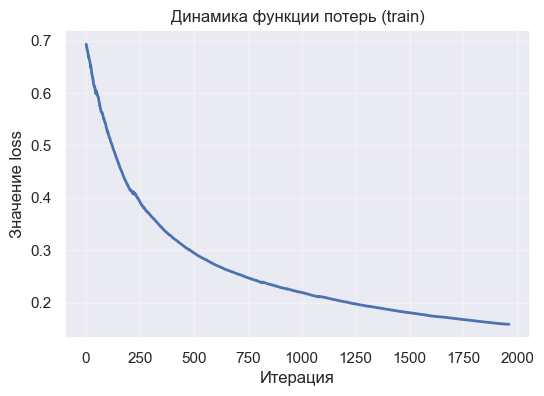

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Динамика функции потерь (train)'}, xlabel='Итерация', ylabel='Значение loss'>)

In [ ]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

kernels = ["linear", "rbf", "poly", "sigmoid"]
Cs = [0.1, 1, 10, 5, 50]

results = []

for kernel in kernels:
    for C in Cs:
        model = make_pipeline(
            StandardScaler(),
            SVC(kernel=kernel, C=C, gamma="scale", probability=True, random_state=42)
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:, 1]

        results.append({
            "kernel": kernel,
            "C": C,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1": f1_score(y_test, y_pred, zero_division=0),
            "AUC-ROC": roc_auc_score(y_test, y_score),
        })

df_metrics = pd.DataFrame(results).sort_values(by="AUC-ROC", ascending=False).reset_index(drop=True)
display(df_metrics)

best = df_metrics.iloc[0]
print(
    f"Лучшее по AUC-ROC: kernel={best['kernel']}, C={best['C']}, "
    f"Acc={best['Accuracy']:.3f}, Prec={best['Precision']:.3f}, "
    f"Rec={best['Recall']:.3f}, F1={best['F1']:.3f}, AUC-ROC={best['AUC-ROC']:.3f}"
)


,kernel,C,Accuracy,Precision,Recall,F1,AUC-ROC
0,rbf,1.0,0.992593,0.988971,0.996296,0.992620,0.997709
1,rbf,0.1,0.994444,0.992620,0.996296,0.994455,0.997531
2,rbf,50.0,0.992593,0.988971,0.996296,0.992620,0.996187
3,linear,50.0,0.992593,0.988971,0.996296,0.992620,0.996022
4,linear,10.0,0.992593,0.988971,0.996296,0.992620,0.995995
5,rbf,5.0,0.992593,0.988971,0.996296,0.992620,0.995926
6,linear,5.0,0.992593,0.988971,0.996296,0.992620,0.995926
7,rbf,10.0,0.992593,0.988971,0.996296,0.992620,0.995816
8,linear,0.1,0.992593,0.988971,0.996296,0.992620,0.995693
9,linear,1.0,0.992593,0.988971,0.996296,0.992620,0.995665


Лучшее по AUC-ROC: kernel=rbf, C=1.0, Acc=0.993, Prec=0.989, Rec=0.996, F1=0.993, AUC-ROC=0.998


#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [ ]:
class HingeLossClassifier(BaseEstimator, ClassifierMixin):
    """
    Линейный классификатор с Hinge loss:
      L(w,b) = mean(max(0, 1 - y*(Xw + b))) + alpha * ||w||^2
    Обучение: градиент/субградиент (полный батч).
    """
    def __init__(self, lr=1e-2, alpha=1e-3, epochs=1000, tol=1e-6, random_state=42, store_loss=True):
        self.lr = lr
        self.alpha = alpha
        self.epochs = epochs
        self.tol = tol
        self.random_state = random_state
        self.store_loss = store_loss

        self.w_ = None
        self.b_ = 0.0
        self.loss_history_ = []

    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        return X @ self.w_ + self.b_

    def predict(self, X):
        scores = self.decision_function(X)
        # возвращаем метки {0,1}
        return (scores >= 0).astype(int)

    def _loss(self, X, y):
        margins = y * (X @ self.w_ + self.b_)
        hinge = np.maximum(0.0, 1.0 - margins)
        return float(np.mean(hinge) + self.alpha * np.sum(self.w_**2))

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)

        if set(np.unique(y)) == {0.0, 1.0}:
            y = np.where(y == 0.0, -1.0, 1.0)
        elif set(np.unique(y)) == {-1.0, 1.0}:
            pass
        else:
            raise ValueError("Ожидаю бинарные метки 0/1 или -1/+1")

        n, m = X.shape
        rng = np.random.RandomState(self.random_state)
        self.w_ = np.zeros(m, dtype=float)
        self.b_ = 0.0
        self.loss_history_.clear()

        prev_loss = np.inf
        for _ in range(self.epochs):
            margins = y * (X @ self.w_ + self.b_)
            active = (margins < 1.0).astype(float)

            grad_w = -(X.T @ (y * active)) / n + 2.0 * self.alpha * self.w_
            grad_b = -np.mean(y * active)

            step_w = self.lr * grad_w
            step_b = self.lr * grad_b
            self.w_ -= step_w
            self.b_ -= step_b

            if self.store_loss:
                cur_loss = self._loss(X, y)
                self.loss_history_.append(cur_loss)
                # критерий остановки: маленькое изменение лосса
                if abs(prev_loss - cur_loss) < self.tol:
                    break
                prev_loss = cur_loss
            else:
                if (np.linalg.norm(step_w)**2 + step_b**2) < self.tol:
                    break

        return self


далее метрики посчитаем

In [ ]:
clf = make_pipeline(
    StandardScaler(),
    HingeLossClassifier(lr=0.05, alpha=1e-3, epochs=2000, tol=1e-7, random_state=42)
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
hinge_model = clf.named_steps['hingelossclassifier']
scores = hinge_model.decision_function(clf.named_steps['standardscaler'].transform(X_test))

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, scores)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"AUC-ROC:   {auc:.3f}")

Accuracy:  0.993
Precision: 0.989
Recall:    0.996
F1-score:  0.993
AUC-ROC:   0.996


выведу наглядно уменьшение лосса на протяжении эпох

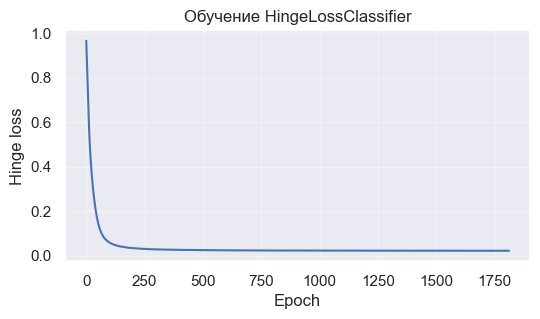

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(hinge_model.loss_history_)
plt.xlabel("Epoch")
plt.ylabel("Hinge loss")
plt.title("Обучение HingeLossClassifier")
plt.grid(True, alpha=0.3)
plt.show()

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
import numpy as np

class KNNClassifier:
    def __init__(self, n_neighbors: int = 5, metric: str = 'euclidean'):
        self.n_neighbors = int(n_neighbors)
        self.metric = metric
        self.X_ = None
        self.y_ = None
        self.classes_ = None

    def _pairwise_dist(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        if self.metric in ('euclidean', 'l2'):
            # sqrt( ||a||^2 + ||b||^2 - 2 a·b )
            A2 = (A ** 2).sum(axis=1)[:, None]
            B2 = (B ** 2).sum(axis=1)[None, :]
            D2 = A2 + B2 - 2.0 * (A @ B.T)
            np.maximum(D2, 0.0, out=D2)      # числ. стабильность
            return np.sqrt(D2)

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)

        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=float)


        D = self._pairwise_dist(X, self.X_)
        idx = np.argpartition(D, self.n_neighbors - 1, axis=1)[:, :self.n_neighbors]

        neigh_y = self.y_[idx]
        n_classes = len(self.classes_)
        proba = np.zeros((X.shape[0], n_classes), dtype=float)
        for j, cls in enumerate(self.classes_):
            proba[:, j] = (neigh_y == cls).sum(axis=1)
        proba /= float(self.n_neighbors)
        return proba

    def predict(self, X: np.ndarray) -> np.ndarray:
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]


In [ ]:
X = np.asarray(X, dtype=float)
y = np.asarray(y)

# по новой делаю полностью тесты, сплиты, чтобы полноценно задание как бы совершить;
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# также по новой делаю стандартизацию, все по ТЗ
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


knn = KNNClassifier(n_neighbors=7, metric='euclidean')
knn.fit(X_train_s, y_train)

y_pred = knn.predict(X_test_s)
proba  = knn.predict_proba(X_test_s)

classes = knn.classes_
if set(classes) == {-1, 1}:
    y_test01 = (y_test == 1).astype(int)
    pos_idx = int(np.where(classes == 1)[0][0])
elif set(classes) == {0, 1}:
    y_test01 = y_test.astype(int)
    pos_idx = int(np.where(classes == 1)[0][0])
else:
    raise ValueError("Этот блок рассчитан на бинарные метки (0/1 или -1/1).")

# метрики
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=classes[pos_idx])
rec = recall_score(y_test, y_pred, pos_label=classes[pos_idx])
f1 = f1_score(y_test, y_pred, pos_label=classes[pos_idx])
auc = roc_auc_score(y_test01, proba[:, pos_idx])

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC-ROC  : {auc:.4f}")


Accuracy : 0.9944
Precision: 0.9926
Recall   : 0.9963
F1-score : 0.9945
AUC-ROC  : 0.9943


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
train = pd.read_csv("fashion-mnist_train.csv")
test = pd.read_csv("fashion-mnist_test.csv")

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.shape

(60000, 785)

In [ ]:
test.shape

(10000, 785)

In [ ]:
df_all = pd.concat([train, test], ignore_index=True)
df_all.shape

(70000, 785)

в сумме получилось 70000 объектов, поэтому как я понимаю, следует разбить на 35 в каждой, причем в рандомном порядке

In [ ]:
seed = 42
rng = np.random.RandomState(seed)
perm = rng.permutation(len(df_all))

idx_A = perm[:35000]
idx_B = perm[35000:70_000]

df_A = df_all.iloc[idx_A].reset_index(drop=True)
df_B = df_all.iloc[idx_B].reset_index(drop=True)

y_A = df_A['label'].to_numpy()
X_A = df_A.drop(columns=['label']).to_numpy(dtype=np.float32) / 255.0

y_B = df_B['label'].to_numpy()
X_B = df_B.drop(columns=['label']).to_numpy(dtype=np.float32) / 255.0

print("A:", X_A.shape, y_A.shape)
print("B:", X_B.shape, y_B.shape)

# контроль на отсутствие пересечений
overlap = np.intersect1d(idx_A, idx_B).size
print("overlap =", overlap)

A: (35000, 784) (35000,)
B: (35000, 784) (35000,)
overlap = 0


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

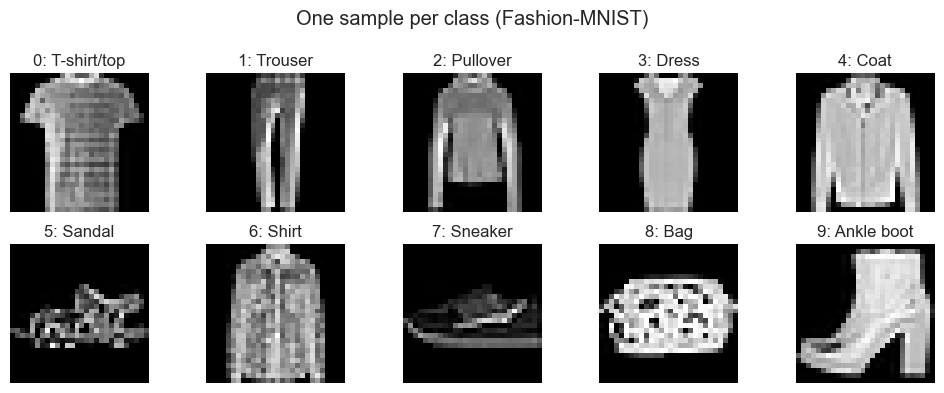

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()

class_names = {
    0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
    5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'
}

for c in range(10):
    i = np.where(y_A == c)[0][0]
    img = X_A[i].reshape(28, 28)
    axes[c].imshow(img, cmap='gray')
    axes[c].set_title(f"{c}: {class_names[c]}")
    axes[c].axis('off')

plt.suptitle("One sample per class (Fashion-MNIST)")
plt.tight_layout()
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X_A_std    = std_scaler.fit_transform(X_A)
X_B_std    = std_scaler.transform(X_B)

X_A_minmax = minmax_scaler.fit_transform(X_A)
X_B_minmax = minmax_scaler.transform(X_B)

print(X_A_std.shape, X_A_minmax.shape)


(35000, 784) (35000, 784)


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_knn = Pipeline([
    ('preprocess', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

param_grid_knn = {
    'preprocess': [StandardScaler(), MinMaxScaler()],
    'clf__n_neighbors': [3, 5, 7, 9, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan'],
    'clf__leaf_size': [20, 30, 40],
}

gs_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid_knn,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
gs_knn.fit(X_A, y_A)

y_pred_knn = gs_knn.predict(X_B)
proba_knn  = gs_knn.predict_proba(X_B)

acc_knn  = accuracy_score(y_B, y_pred_knn)
prec_knn = precision_score(y_B, y_pred_knn, average='weighted', zero_division=0)
rec_knn  = recall_score(y_B, y_pred_knn, average='weighted', zero_division=0)
f1_knn   = f1_score(y_B, y_pred_knn, average='weighted', zero_division=0)
auc_knn  = roc_auc_score(y_B, proba_knn, multi_class='ovr')

print("KNN — best CV accuracy:", gs_knn.best_score_)
print("KNN — best params:", gs_knn.best_params_)
print(f"KNN — TEST  Acc={acc_knn:.4f}  Prec_w={prec_knn:.4f}  Recall_w={rec_knn:.4f}  F1_w={f1_knn:.4f}  AUC-ROC(ovr)={auc_knn:.4f}")

pipe_lr = Pipeline([
    ('preprocess', StandardScaler()),
    ('clf', LogisticRegression(max_iter=200))
])

# здесь аккуратно делаю раздельные сетки
param_grid_lr = [
    {
        'preprocess': [StandardScaler(), MinMaxScaler()],
        'clf__solver': ['liblinear'],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.01, 0.1, 1, 3, 10],
        'clf__class_weight': [None, 'balanced'],
    },
    {
        'preprocess': [StandardScaler(), MinMaxScaler()],
        'clf__solver': ['saga'],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.01, 0.1, 1, 3, 10],
        'clf__class_weight': [None, 'balanced'],
        'clf__max_iter': [200]  # явно фиксируем
    },
]

gs_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
gs_lr.fit(X_A, y_A)

y_pred_lr = gs_lr.predict(X_B)
proba_lr  = gs_lr.predict_proba(X_B)

acc_lr  = accuracy_score(y_B, y_pred_lr)
prec_lr = precision_score(y_B, y_pred_lr, average='weighted', zero_division=0)
rec_lr  = recall_score(y_B, y_pred_lr, average='weighted', zero_division=0)
f1_lr   = f1_score(y_B, y_pred_lr, average='weighted', zero_division=0)
auc_lr  = roc_auc_score(y_B, proba_lr, multi_class='ovr')

print("\nLogReg — best CV accuracy:", gs_lr.best_score_)
print("LogReg — best params:", gs_lr.best_params_)
print(f"LogReg — TEST  Acc={acc_lr:.4f}  Prec_w={prec_lr:.4f}  Recall_w={rec_lr:.4f}  F1_w={f1_lr:.4f}  AUC-ROC(ovr)={auc_lr:.4f}")

print("\nClassification report (LogReg):")
print(classification_report(y_B, y_pred_lr, digits=3))


Fitting 5 folds for each of 120 candidates, totalling 600 fits


## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.